In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from sklearn.utils import resample

# Load Data

## Dataset

https://www.kaggle.com/datasets/msambare/fer2013

Emotion label
- 0: angry
- 1: disgust
- 2: fear
- 3: happy
- 4: sad
- 5: surprise
- 6: neutral

In [2]:
# Data folders
train_dir = '../data/external/fer2013/train'
test_dir = '../data/external/fer2013/test'

# Emotion labels
emotion_labels = {0:'angry', 1:'disgust', 2:'fear', 3:'happy', 4:'sad', 5:'surprise', 6:'neutral'}
emotions = {val: key for key, val in emotion_labels.items()} 

In [3]:
def get_data(usage):
    image_data = []
    
    folder = train_dir
    if usage == 'test':
        folder = test_dir
        
    for dirname, dirs, filenames in os.walk(folder, topdown=True):
        cat = dirname.replace(folder, '')
        if cat != '':
            cat = cat.replace('/', '')
            for filename in filenames:
                file = os.path.join(dirname, filename)
                image = mpimg.imread(file).flatten()
                pixels = ' '.join(str(x) for x in image)

                image_data.append([usage, emotions[cat], pixels])
    return image_data

In [4]:
image_data1 = get_data('train')
image_data2 = get_data('test')
image_data = image_data1 + image_data2

In [5]:
df = pd.DataFrame(image_data, columns = ['usage', 'emotion', 'pixels'])
df.head()

,usage,emotion,pixels
0,train,3,108 83 63 65 89 111 121 121 125 111 103 105 11...
1,train,3,137 142 159 162 158 134 113 167 174 177 164 12...
2,train,3,111 148 155 167 181 191 194 193 195 199 203 20...
3,train,3,151 156 121 100 80 116 151 169 183 185 192 190...
4,train,3,248 187 149 130 97 140 139 117 197 251 231 255...


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   usage    35887 non-null  object
 1   emotion  35887 non-null  int64 
 2   pixels   35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


# Data Cleaning

There is no missing data, no outlier, all pixel data are within the range, 0 to 255. 

## Delete Black or White images

In [7]:
del_idx = []
for index, row in df.iterrows():
    arr = np.fromstring(row.pixels, dtype=int, sep=' ')
    image_sum = np.sum(arr)
    if (image_sum == 0) | (image_sum == (255 * 2304)):
        del_idx.append(index)

In [8]:
print(len(del_idx))
df.loc[del_idx]

12


,usage,emotion,pixels
2801,train,3,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
10605,train,4,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
19240,train,5,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
21055,train,6,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
24441,train,0,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
24735,train,0,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
24754,train,0,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
25168,train,0,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
25465,train,0,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
27134,train,0,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...


In [9]:
df.drop(del_idx, inplace=True)

# EDA

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35875 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   usage    35875 non-null  object
 1   emotion  35875 non-null  int64 
 2   pixels   35875 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


In [11]:
print(df[df['usage']=='train'].shape)
print(df[df['usage']=='test'].shape)

(28698, 3)
(7177, 3)


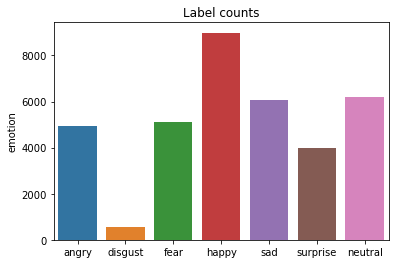

In [12]:
sns.barplot(x = df.emotion.value_counts().index, y = df.emotion.value_counts())
plt.xticks(list(emotion_labels.keys()), list(emotion_labels.values()))
plt.title('Label counts')
plt.show()

In [13]:
df['emotion'].value_counts()

3    8988
6    6197
4    6076
2    5121
0    4945
5    4001
1     547
Name: emotion, dtype: int64

## Balance disgust label

Make disgust label almost same count as surprize label

In [14]:
# Check surprise count
df[df['emotion']==5]['usage'].value_counts()

train    3170
test      831
Name: usage, dtype: int64

In [15]:
X_train_disgust = df[df['emotion']==1]['pixels']
y_train_disgust = df[df['emotion']==1]['emotion']
X_test_disgust = df[df['emotion']==1]['pixels']
y_test_disgust = df[df['emotion']==1]['emotion']

In [16]:
n_sample_train = 3170
n_sample_test = 830

X_train, y_train = resample(X_train_disgust,
                    y_train_disgust,
                    replace=True,
                    n_samples=n_sample_train,
                    random_state=123)

X_test, y_test = resample(X_test_disgust,
                    y_test_disgust,
                    replace=True,
                    n_samples=n_sample_test,
                    random_state=123)

In [17]:
print(X_train.shape)
print(X_test.shape)

(3170,)
(830,)


In [19]:
disgust_data = []
for index, row in X_train.items():
    disgust_data.append(['train', 1, row])

for index, row in X_test.items():
    disgust_data.append(['test', 1, row])

In [20]:
df_new = df[df['emotion']!=1]
df_disgust = pd.DataFrame(disgust_data, columns = ['usage', 'emotion', 'pixels'])
df_new = pd.concat([df_new, df_disgust], axis=0)
df_new.head()

,usage,emotion,pixels
0,train,3,108 83 63 65 89 111 121 121 125 111 103 105 11...
1,train,3,137 142 159 162 158 134 113 167 174 177 164 12...
2,train,3,111 148 155 167 181 191 194 193 195 199 203 20...
3,train,3,151 156 121 100 80 116 151 169 183 185 192 190...
4,train,3,248 187 149 130 97 140 139 117 197 251 231 255...


In [21]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39328 entries, 0 to 3999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   usage    39328 non-null  object
 1   emotion  39328 non-null  int64 
 2   pixels   39328 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


In [22]:
print(df_new[df_new['usage']=='train'].shape)
print(df_new[df_new['usage']=='test'].shape)

(31432, 3)
(7896, 3)


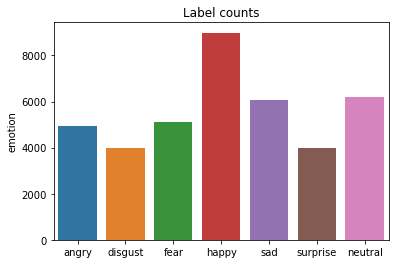

In [23]:
sns.barplot(x = df_new.emotion.value_counts().index, y = df_new.emotion.value_counts())
plt.xticks(list(emotion_labels.keys()), list(emotion_labels.values()))
plt.title('Label counts')
plt.show()

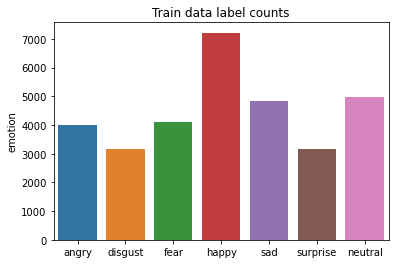

In [24]:
sns.barplot(x = df_new[df_new['usage']=='train'].emotion.value_counts().index, y =df_new[df_new['usage']=='train'].emotion.value_counts())
plt.xticks(list(emotion_labels.keys()), list(emotion_labels.values()))
plt.title('Train data label counts')
plt.show()

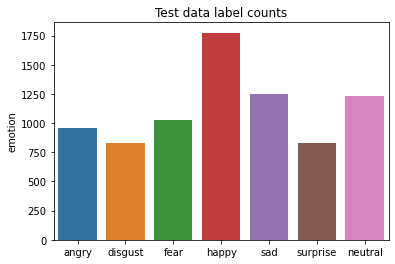

In [25]:
sns.barplot(x = df_new[df_new['usage']=='test'].emotion.value_counts().index, y = df_new[df_new['usage']=='test'].emotion.value_counts())
plt.xticks(list(emotion_labels.keys()), list(emotion_labels.values()))
plt.title('Test data label counts')
plt.show()

## Show pictures for each emotion

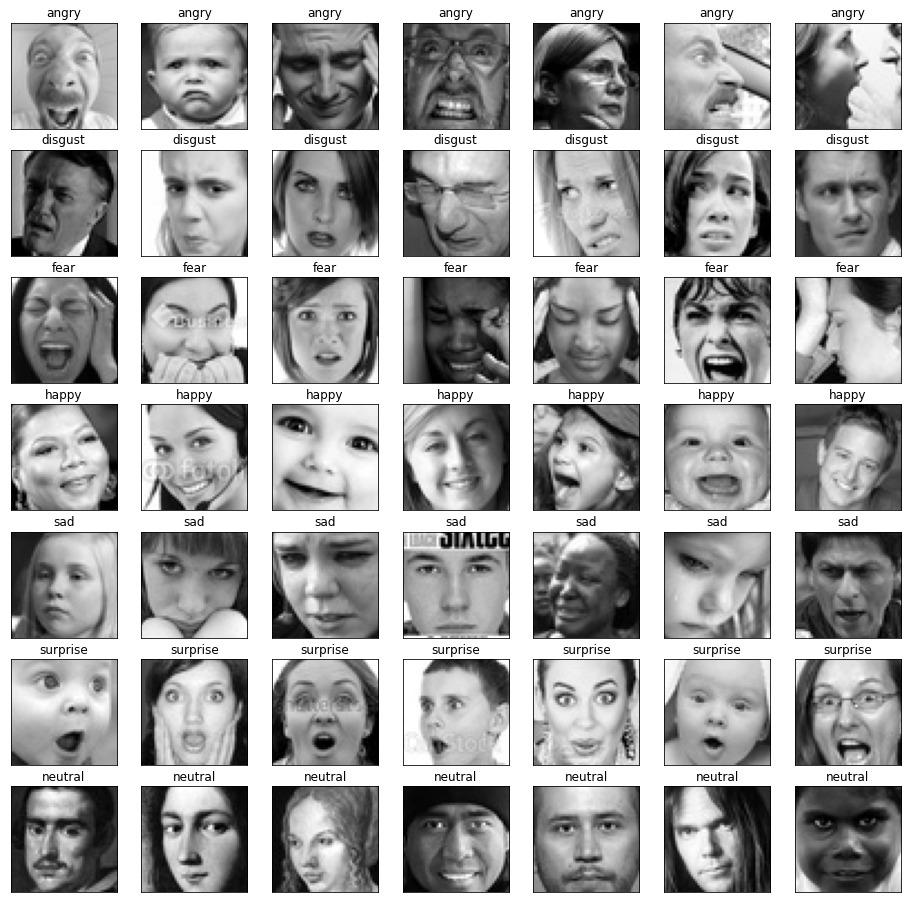

In [29]:
plt.figure(figsize=(16,16))
k = 0
for emo_num in sorted(df_new.emotion.unique()):
    for j in range(7):
        img = df_new[df_new.emotion==emo_num].iloc[k].pixels
        img = np.array(img.split(' ')).reshape(48, 48).astype('int')

        k += 1
        plt.subplot(7,7,k)
        plt.imshow(img, cmap='gray')
        plt.xticks([])
        plt.yticks([])
        plt.title(emotion_labels[emo_num])
plt.show()

# Export data

In [30]:
df_data = df_new[['usage', 'emotion', 'pixels']].copy()
df_data.head()

,usage,emotion,pixels
0,train,3,108 83 63 65 89 111 121 121 125 111 103 105 11...
1,train,3,137 142 159 162 158 134 113 167 174 177 164 12...
2,train,3,111 148 155 167 181 191 194 193 195 199 203 20...
3,train,3,151 156 121 100 80 116 151 169 183 185 192 190...
4,train,3,248 187 149 130 97 140 139 117 197 251 231 255...


In [31]:
file = '../data/fer_data.csv'
df_data.to_csv(file, index=False)

## Load data example

In [32]:
df = pd.read_csv(file)

In [33]:
def load_data(df):
    image_pixels = []
    image_scaled = []
    image_labels = list(df.emotion)
    
    for index, row in df.iterrows():
        image = np.fromstring(row.pixels, dtype=int, sep=' ')
        scale = image / 255.0
        image_pixels.append(image)
        image_scaled.append(scale)
        
    return image_pixels, image_scaled, image_labels

In [34]:
X, X_scale, y = load_data(df_data[df_data['usage']=='train'])

In [35]:
len(X)

31432

In [36]:
len(y)

31432

In [37]:
df_data[df_data['usage']=='train'].shape

(31432, 3)

In [38]:
X[0]

array([108,  83,  63, ..., 116, 122, 122])